In [1]:
import os
import tarfile
import numpy as np
import cv2
import nibabel as nib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau
import matplotlib.pyplot as plt

2025-09-08 15:33:32.456571: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 15:33:32.467523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757325812.480872  175075 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757325812.484994  175075 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-08 15:33:32.499349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
extracted_dir = "/home/user/Tf_script/dataset/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"

In [3]:
IMG_SIZE = 128  # or 256 if padding for UNet
VOLUME_SLICES = 155  # full axial slices
VOLUME_START_AT = 0  # don’t skip
NUM_CLASSES = 1  # per head (binary heads)

In [4]:
# ====== Dice metric/loss ======
def dice_coef_binary(y_true, y_pred, smooth=1.0):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_binary_loss(y_true, y_pred):
    return 1.0 - dice_coef_binary(y_true, y_pred)

In [5]:
# ====== Simple UNet blocks ======
def conv_block(x, filters, kernel_size=3, padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [6]:
# ====== UNet model builder (multi-head outputs) ======
def build_unet_multihead(input_shape, num_classes=1):
    inputs = Input(input_shape, name="input_image")

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    u1 = UpSampling2D((2, 2))(bn)
    u1 = concatenate([u1, c4])
    d1 = conv_block(u1, 512)

    u2 = UpSampling2D((2, 2))(d1)
    u2 = concatenate([u2, c3])
    d2 = conv_block(u2, 256)

    u3 = UpSampling2D((2, 2))(d2)
    u3 = concatenate([u3, c2])
    d3 = conv_block(u3, 128)

    u4 = UpSampling2D((2, 2))(d3)
    u4 = concatenate([u4, c1])
    d4 = conv_block(u4, 64)

    # Three separate 1x1 conv heads (sigmoid for binary masks)
    necrotic_output = Conv2D(num_classes, (1, 1), activation='sigmoid', name='necrotic_output')(d4)
    enhancing_output = Conv2D(num_classes, (1, 1), activation='sigmoid', name='enhancing_output')(d4)
    edema_output = Conv2D(num_classes, (1, 1), activation='sigmoid', name='edema_output')(d4)

    model = Model(inputs=inputs, outputs=[necrotic_output, enhancing_output, edema_output], name="UNet_MultiHead")
    return model

In [7]:
# ====== Data Generator (FLAIR only, 1 channel) ======
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_ids = [self.list_IDs[k] for k in idxs]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        # Each case yields VOLUME_SLICES 2D slices; we'll stack them per batch case
        total_slices = self.batch_size * VOLUME_SLICES
        X = np.zeros((total_slices, *self.dim, self.n_channels), dtype=np.float32)
        necrotic_mask = np.zeros((total_slices, *self.dim, 1), dtype=np.float32)
        edema_mask = np.zeros((total_slices, *self.dim, 1), dtype=np.float32)
        enhancing_mask = np.zeros((total_slices, *self.dim, 1), dtype=np.float32)

        for c, case_id in enumerate(batch_ids):
            case_path = os.path.join(extracted_dir, case_id)
            flair_path = os.path.join(case_path, f'{case_id}-t2f.nii.gz')  # FLAIR
            seg_path = os.path.join(case_path, f'{case_id}-seg.nii.gz')    # segmentation mask

            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                sl = j + VOLUME_START_AT
                idx = j + VOLUME_SLICES * c

                # Handle bounds (in case VOLUME_SLICES > actual slices)
                if sl >= flair.shape[2] or sl >= seg.shape[2]:
                    # if out of bounds, keep zeros (or you could repeat last slice)
                    continue

                # Resize image
                img = cv2.resize(flair[:, :, sl], self.dim, interpolation=cv2.INTER_LINEAR).astype(np.float32)
                # normalize later after filling batch to avoid division by zero
                X[idx, :, :, 0] = img

                # prepare label slice and remap label 4->3 if present
                lab = seg[:, :, sl].copy()
                lab[lab == 4] = 3

                # binary heads as in your original mapping
                nec = (lab >= 1).astype(np.uint8)
                ed = (lab >= 2).astype(np.uint8)
                enh = (lab >= 3).astype(np.uint8)

                # Resize masks using nearest neighbor
                nec_res = cv2.resize(nec, self.dim, interpolation=cv2.INTER_NEAREST).astype(np.float32)
                ed_res = cv2.resize(ed, self.dim, interpolation=cv2.INTER_NEAREST).astype(np.float32)
                enh_res = cv2.resize(enh, self.dim, interpolation=cv2.INTER_NEAREST).astype(np.float32)

                necrotic_mask[idx, :, :, 0] = nec_res
                edema_mask[idx, :, :, 0] = ed_res
                enhancing_mask[idx, :, :, 0] = enh_res

        # Normalize input safely per-batch
        mx = X.max()
        if mx > 0:
            X = X / mx

        return X, {
            'necrotic_output': necrotic_mask,
            'edema_output': edema_mask,
            'enhancing_output': enhancing_mask
        }

In [8]:
# ====== Gather case IDs from extracted_dir ======
def pathListIntoIds(dirList):
    return [os.path.basename(d) for d in dirList]

all_directories = [f.path for f in os.scandir(extracted_dir) if f.is_dir()]
all_ids = [d[d.rfind('/')+1:] for d in all_directories]
all_ids = all_ids[:450]

# Splits
train_test_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Generators
train_gen = DataGenerator(train_ids, batch_size=1, shuffle=True)
val_gen = DataGenerator(val_ids, batch_size=1, shuffle=False)
test_gen = DataGenerator(test_ids, batch_size=1, shuffle=False)

# ====== Build & Compile UNet ======
model = build_unet_multihead((IMG_SIZE, IMG_SIZE, 1), NUM_CLASSES)
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss={
        'necrotic_output': dice_coef_binary_loss,
        'enhancing_output': dice_coef_binary_loss,
        'edema_output': dice_coef_binary_loss
    },
    metrics={
        'necrotic_output': ['accuracy', dice_coef_binary],
        'enhancing_output': ['accuracy', dice_coef_binary],
        'edema_output': ['accuracy', dice_coef_binary]
    }
)
model.summary()


I0000 00:00:1757325828.287584  175075 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14400 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:19:00.0, compute capability: 8.6


Model: "UNet_MultiHead"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_image[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,401,475 (119.79 MB)

 Trainable params: 31,389,699 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [9]:
# ====== Callbacks ======
callbacks = [
    CSVLogger('training_unet_multihead.log'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# ====== Train (small test run) ======
model.fit(
    train_gen,
    epochs=80,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

/home/user/anaconda3/envs/ashu_segments/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80


I0000 00:00:1757325849.504060  175212 service.cc:148] XLA service 0x7f25dc0022c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757325849.504098  175212 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-09-08 15:34:09.875215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757325850.891927  175212 cuda_dnn.cc:529] Loaded cuDNN version 90101
E0000 00:00:1757325856.192987  175212 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757325856.383418  175212 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-08 15:34:42.507993: E external/local

306/306 ━━━━━━━━━━━━━━━━━━━━ 669s 2s/step - edema_output_accuracy: 0.9805 - edema_output_dice_coef_binary: 0.2825 - edema_output_loss: 0.7175 - enhancing_output_accuracy: 0.6610 - enhancing_output_dice_coef_binary: 0.0119 - enhancing_output_loss: 0.9881 - loss: 2.6466 - necrotic_output_accuracy: 0.7980 - necrotic_output_dice_coef_binary: 0.0590 - necrotic_output_loss: 0.9410 - val_edema_output_accuracy: 0.9919 - val_edema_output_dice_coef_binary: 0.0030 - val_edema_output_loss: 0.9970 - val_enhancing_output_accuracy: 0.9977 - val_enhancing_output_dice_coef_binary: 0.0034 - val_enhancing_output_loss: 0.9966 - val_loss: 2.9902 - val_necrotic_output_accuracy: 0.7791 - val_necrotic_output_dice_coef_binary: 0.0034 - val_necrotic_output_loss: 0.9966 - learning_rate: 3.0000e-04
Epoch 2/80
306/306 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - edema_output_accuracy: 0.9933 - edema_output_dice_coef_binary: 0.5656 - edema_output_loss: 0.4344 - enhancing_output_accuracy: 0.9877 - enhancing_output_dice_coef_

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


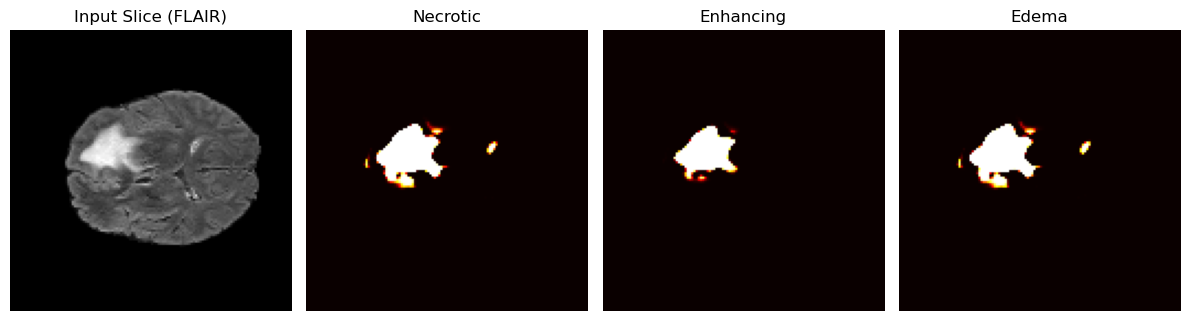

In [10]:
# ====== Inference on a single FLAIR slice (example) ======
sample_dir = all_directories[0]
case_id = os.path.basename(sample_dir)
flair_path = os.path.join(sample_dir, f"{case_id}-t2f.nii.gz")

flair_nii = nib.load(flair_path)
flair_img = flair_nii.get_fdata()
slice_idx = flair_img.shape[2] // 2
slice_img = flair_img[:, :, slice_idx]

slice_img_resized = cv2.resize(slice_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR).astype(np.float32)
slice_img_norm = (slice_img_resized - slice_img_resized.min()) / (slice_img_resized.max() - slice_img_resized.min() + 1e-8)
input_tensor = np.expand_dims(slice_img_norm, axis=(0, -1))

necrotic_pred, enhancing_pred, edema_pred = model.predict(input_tensor)
necrotic_pred = necrotic_pred[0, :, :, 0]
enhancing_pred = enhancing_pred[0, :, :, 0]
edema_pred = edema_pred[0, :, :, 0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1); plt.title("Input Slice (FLAIR)"); plt.imshow(slice_img_norm, cmap='gray'); plt.axis('off')
plt.subplot(1, 4, 2); plt.title("Necrotic"); plt.imshow(necrotic_pred, cmap='hot'); plt.axis('off')
plt.subplot(1, 4, 3); plt.title("Enhancing"); plt.imshow(enhancing_pred, cmap='hot'); plt.axis('off')
plt.subplot(1, 4, 4); plt.title("Edema"); plt.imshow(edema_pred, cmap='hot'); plt.axis('off')
plt.tight_layout(); plt.show()